# Notebook used for NK cell analysis version 2
Building up a bit more to a better story by looking at the properties of the NK cells before jumping to a story right away\
1.30.24 Zach Leon

In [1]:
#import libraries
#import libraries:
import os
import pandas as pd
import numpy as np
import glob
import warnings
import re
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import zscore, mannwhitneyu, ttest_ind, shapiro
from alpineer import io_utils, load_utils, misc_utils
import seaborn as sns
import matplotlib.patches as mpatches
import scipy.stats as stats
import shutil
from PIL import Image

#import data and change directory back to working directory:
os.chdir('/krummellab/data1/DSCoLab/HNLN')
#read in paths to files.
cell_table = pd.read_csv('cell_table/meta_data_cell_table_combined.csv')
segmentation = 'segmentation/' #have to work on how to save each of these as a numpy data array or a series of them as a numpy array for visualization.
dist_data = pd.read_csv('spatial_analysis/cell_neighbor_analysis/cell_meta_cluster_avg_dists-nearest_5.csv')
freq_data = pd.read_csv('spatial_analysis/neighborhood_mats/neighborhood_freqs-cell_meta_cluster_radius50.csv')

os.chdir('/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_MR_NK_analysis')
os.getcwd()

/scratch/zachsten/1676733/ipykernel_237075/787800531.py:22: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_table = pd.read_csv('cell_table/meta_data_cell_table_combined.csv')


'/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_MR_NK_analysis'

In [2]:
#optional read in original Maha data for some data that may have been missed per cell we want to incoroprate:
os.chdir('/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_single_ch_tifs/')
extra_data = pd.read_csv('cell_table/cell_table_arcsinh_transformed_large_removed_CD8_regions_neighborhoods_functional.csv')
os.chdir('/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_MR_NK_analysis')
os.getcwd()

/scratch/zachsten/1676733/ipykernel_237075/1250690840.py:3: DtypeWarning: Columns (130,136) have mixed types. Specify dtype option on import or set low_memory=False.
  extra_data = pd.read_csv('cell_table/cell_table_arcsinh_transformed_large_removed_CD8_regions_neighborhoods_functional.csv')


'/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_MR_NK_analysis'

## Assess the overall number and frequency of NK cells using the appropraite statistical analysis for distribution of the data.
T-test = appropriate for data between two independent groups that's normally distributed.\
Mann-Whitney U test = appropraiate for data between two independent groups that's NOT normally distributed\
\
Shapiro-Wilk test = measures if data is normally distributed by calculating mean and SD. Close to 1 = perfectly normal, lower means not. After the W statistic is calculated, it is compared against a distribution of W values expected from a normally distributed dataset of the same size. This comparison yields the p-value.\
\
Shapiro is calculated for each population treated (n = 9) and not (n = 22) since there is an unequal number between the two groups. 


T-test used for NK cell counts
T-test used for NK cell frequencies


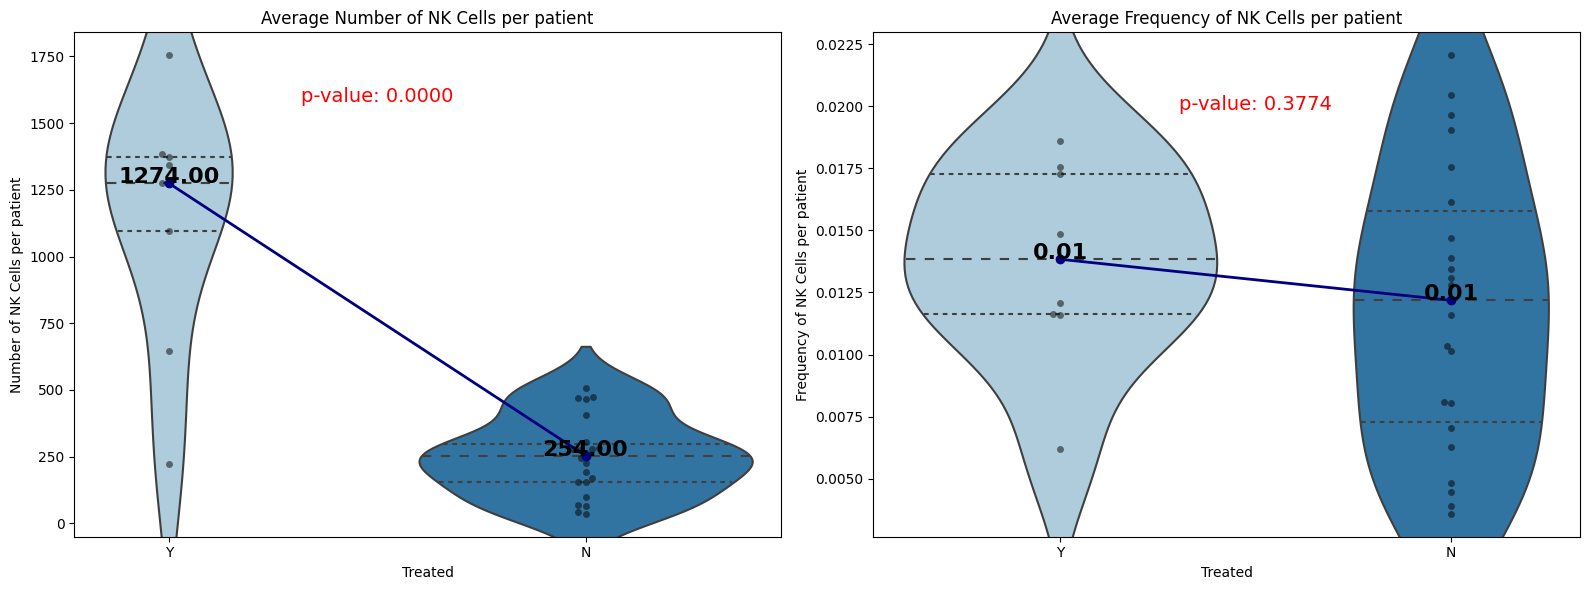

In [7]:
nk_cells_df = cell_table[cell_table['cell_meta_cluster'] == 'NK_cell']
# Calculate the number of NK cells per fov for each core_status
nk_cells_counts = nk_cells_df.groupby(['treated', 'patient_id']).size().reset_index(name='nk_cell_count')
# Calculate the frequency of NK cells out of the total number of cells in each fov
total_cells_per_fov = cell_table.groupby('patient_id').size()
nk_cells_frequency = nk_cells_counts.copy()
nk_cells_frequency['nk_cell_freq'] = nk_cells_frequency.apply(lambda x: x['nk_cell_count'] / total_cells_per_fov[x['patient_id']], axis=1)

# Separate normality test for treated and untreated groups for NK cell counts
shapiro_test_count_treated = shapiro(nk_cells_counts[nk_cells_counts['treated'] == 'Y']['nk_cell_count'])
shapiro_test_count_untreated = shapiro(nk_cells_counts[nk_cells_counts['treated'] == 'N']['nk_cell_count'])

# Separate normality test for treated and untreated groups for NK cell frequencies
shapiro_test_freq_treated = shapiro(nk_cells_frequency[nk_cells_frequency['treated'] == 'Y']['nk_cell_freq'])
shapiro_test_freq_untreated = shapiro(nk_cells_frequency[nk_cells_frequency['treated'] == 'N']['nk_cell_freq'])

# Determine which test to use based on the normality results
# For NK cell counts
if shapiro_test_count_treated.pvalue < 0.05 or shapiro_test_count_untreated.pvalue < 0.05:
    # Use Mann-Whitney U test if either group is not normally distributed
    stat, p_value_counts = mannwhitneyu(nk_cells_counts[nk_cells_counts['treated'] == 'Y']['nk_cell_count'],
                                        nk_cells_counts[nk_cells_counts['treated'] == 'N']['nk_cell_count'])
    print("Mann-Whitney U test used for NK cell counts")
else:
    # Use t-test if both groups are normally distributed
    stat, p_value_counts = ttest_ind(nk_cells_counts[nk_cells_counts['treated'] == 'Y']['nk_cell_count'],
                                     nk_cells_counts[nk_cells_counts['treated'] == 'N']['nk_cell_count'])
    print("T-test used for NK cell counts")

# For NK cell frequencies
if shapiro_test_freq_treated.pvalue < 0.05 or shapiro_test_freq_untreated.pvalue < 0.05:
    # Use Mann-Whitney U test if either group is not normally distributed
    stat, p_value_freq = mannwhitneyu(nk_cells_frequency[nk_cells_frequency['treated'] == 'Y']['nk_cell_freq'],
                                      nk_cells_frequency[nk_cells_frequency['treated'] == 'N']['nk_cell_freq'])
    print("Mann-Whitney U test used for NK cell frequencies")
else:
    # Use t-test if both groups are normally distributed
    stat, p_value_freq = ttest_ind(nk_cells_frequency[nk_cells_frequency['treated'] == 'Y']['nk_cell_freq'],
                                   nk_cells_frequency[nk_cells_frequency['treated'] == 'N']['nk_cell_freq'])
    print("T-test used for NK cell frequencies")

# Set the figure parameters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
palette = sns.color_palette("Paired")
category_order = ['Y', 'N']

# Function to map category names to their positions
def map_categories_to_positions(categories, order):
    return [order.index(cat) for cat in categories]

# Calculate medians for the NK cell counts
median_counts = nk_cells_counts.groupby('treated')['nk_cell_count'].median()

# Calculate medians for the NK cell frequencies
median_freq = nk_cells_frequency.groupby('treated')['nk_cell_freq'].median()

# Modify the plotting section to include the medians and lines
# Plot for count of NK cells per patient
sns.violinplot(x='treated', y='nk_cell_count', data=nk_cells_counts, order=category_order, inner="quart", palette=palette, ax=axes[0])
sns.swarmplot(x='treated', y='nk_cell_count', data=nk_cells_counts, order=category_order, color='k', alpha=0.5, ax=axes[0])
axes[0].set_xlabel('Treated')
axes[0].set_ylabel('Number of NK Cells per patient')
axes[0].set_title('Average Number of NK Cells per patient')

# Add median values, line, and p-value for NK cell counts
x_coords_counts = map_categories_to_positions(median_counts.index, category_order)
for x, med_val in zip(x_coords_counts, median_counts):
    axes[0].scatter(x, med_val, color='navy', zorder=3)
    axes[0].text(x, med_val, f'{med_val:.2f}', color='black', ha='center', fontsize=16, fontweight='bold')
axes[0].plot(x_coords_counts, median_counts.values, color='navy', linestyle='-', linewidth=2)
axes[0].text(0.5, max(nk_cells_counts['nk_cell_count']) * 0.9, f'p-value: {p_value_counts:.4f}', color='red', ha='center', fontsize=14)

# Plot for frequency of NK cells per patient
sns.violinplot(x='treated', y='nk_cell_freq', data=nk_cells_frequency, order=category_order, inner="quart", palette=palette, ax=axes[1])
sns.swarmplot(x='treated', y='nk_cell_freq', data=nk_cells_frequency, order=category_order, color='k', alpha=0.5, ax=axes[1])
axes[1].set_xlabel('Treated')
axes[1].set_ylabel('Frequency of NK Cells per patient')
axes[1].set_title('Average Frequency of NK Cells per patient')

# Add median values, line, and p-value for NK cell frequencies
x_coords_freq = map_categories_to_positions(median_freq.index, category_order)
for x, med_val in zip(x_coords_freq, median_freq):
    axes[1].scatter(x, med_val, color='navy', zorder=3)
    axes[1].text(x, med_val, f'{med_val:.2f}', color='black', ha='center', fontsize=16, fontweight='bold')
axes[1].plot(x_coords_freq, median_freq.values, color='navy', linestyle='-', linewidth=2)
axes[1].text(0.5, max(nk_cells_frequency['nk_cell_freq']) * 0.9, f'p-value: {p_value_freq:.4f}', color='red', ha='center', fontsize=14)

plt.tight_layout()
plt.show()

## Assess the differences in compartmentalization of the NK cells across patient groups
Like before we are calculating the normality of the data seperately for each group and if one of them is non-normal we use the Mann Whitney test.\
\
This is calculated first but in instances where there are too few patients i.e. < 3 to calculate this from then that region is still plotted but stats aren't calculated.\
The reason Tumor isn't calculated is because of too few patients in the non-treated group. Results below.

Skipping statistical tests for region Tumor due to insufficient data.


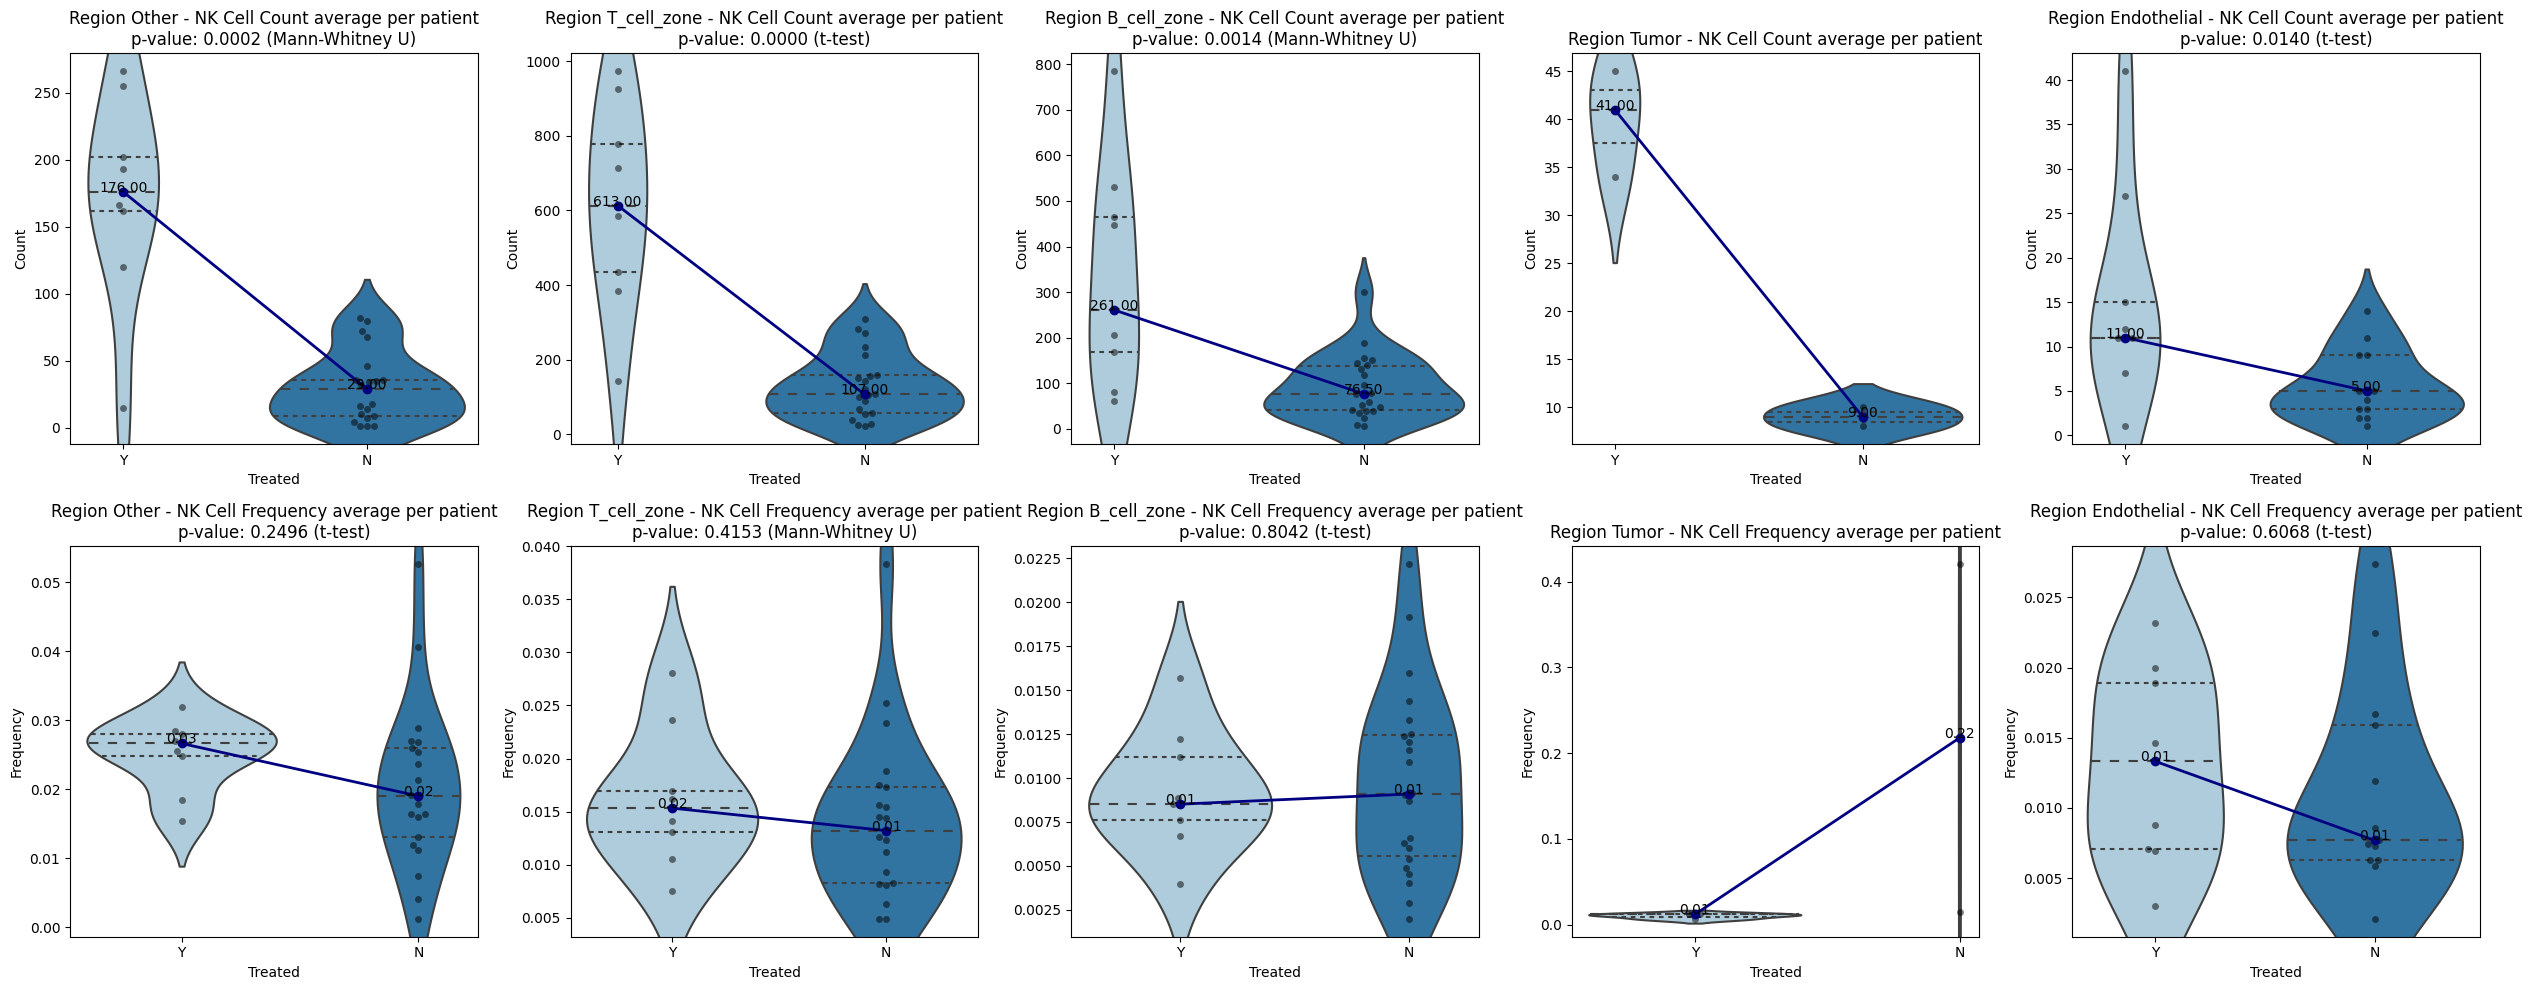

In [36]:
# Assuming 'cell_table' is your DataFrame and is already defined
nk_cells_df = cell_table[cell_table['cell_meta_cluster'] == 'NK_cell']

# Initialize figure layout
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))  # Adjust size as needed
palette = sns.color_palette("Paired")
category_order = ['Y', 'N']

# Function to map category names to their positions
def map_categories_to_positions(categories, order):
    return [order.index(cat) for cat in categories]

# Loop through each unique region
for i, region in enumerate(nk_cells_df['region'].unique()):
    # Subset NK cells by region
    region_nk_cells_df = nk_cells_df[nk_cells_df['region'] == region]

    # Calculate the number and frequency of NK cells
    region_nk_cells_counts = region_nk_cells_df.groupby(['treated', 'patient_id']).size().reset_index(name='nk_cell_count')
    region_total_cells_per_fov = cell_table[cell_table['region'] == region].groupby('patient_id').size()
    region_nk_cells_frequency = region_nk_cells_counts.copy()
    region_nk_cells_frequency['nk_cell_freq'] = region_nk_cells_frequency.apply(lambda x: x['nk_cell_count'] / region_total_cells_per_fov[x['patient_id']], axis=1)

    # Calculate medians for the NK cell counts and frequencies
    median_counts = region_nk_cells_counts.groupby('treated')['nk_cell_count'].median()
    median_freq = region_nk_cells_frequency.groupby('treated')['nk_cell_freq'].median()

    # Check for sufficient data points
    treated_counts = region_nk_cells_counts[region_nk_cells_counts['treated'] == 'Y']['nk_cell_count']
    untreated_counts = region_nk_cells_counts[region_nk_cells_counts['treated'] == 'N']['nk_cell_count']
    treated_freq = region_nk_cells_frequency[region_nk_cells_frequency['treated'] == 'Y']['nk_cell_freq']
    untreated_freq = region_nk_cells_frequency[region_nk_cells_frequency['treated'] == 'N']['nk_cell_freq']

    skip_statistical_tests = False
    if len(treated_counts) < 3 or len(untreated_counts) < 3 or len(treated_freq) < 3 or len(untreated_freq) < 3:
        print(f"Skipping statistical tests for region {region} due to insufficient data.")
        skip_statistical_tests = True

    # Perform statistical tests only if data points are sufficient
    test_used_counts = ""
    test_used_freq = ""
    p_value_counts = None
    p_value_freq = None
    if not skip_statistical_tests:
        if shapiro(treated_counts).pvalue < 0.05 or shapiro(untreated_counts).pvalue < 0.05:
            stat, p_value_counts = mannwhitneyu(treated_counts, untreated_counts)
            test_used_counts = "Mann-Whitney U"
        else:
            stat, p_value_counts = ttest_ind(treated_counts, untreated_counts)
            test_used_counts = "t-test"

        if shapiro(treated_freq).pvalue < 0.05 or shapiro(untreated_freq).pvalue < 0.05:
            stat, p_value_freq = mannwhitneyu(treated_freq, untreated_freq)
            test_used_freq = "Mann-Whitney U"
        else:
            stat, p_value_freq = ttest_ind(treated_freq, untreated_freq)
            test_used_freq = "t-test"

    # Plotting NK cell count
    sns.violinplot(x='treated', y='nk_cell_count', data=region_nk_cells_counts, order=category_order, inner="quart", palette=palette, ax=axes[0, i])
    sns.swarmplot(x='treated', y='nk_cell_count', data=region_nk_cells_counts, order=category_order, color='k', alpha=0.5, ax=axes[0, i])
    title = f'Region {region} - NK Cell Count average per patient'
    if p_value_counts is not None:
        title += f'\np-value: {p_value_counts:.4f} ({test_used_counts})'
    axes[0, i].set_title(title)
    axes[0, i].set_xlabel('Treated')
    axes[0, i].set_ylabel('Count')

    # Add median values and line for NK cell counts
    x_coords_counts = map_categories_to_positions(median_counts.index, category_order)
    for x, med_val in zip(x_coords_counts, median_counts):
        axes[0, i].scatter(x, med_val, color='navy', zorder=3)
        axes[0, i].text(x, med_val, f'{med_val:.2f}', color='black', ha='center', fontsize=10)
    axes[0, i].plot(x_coords_counts, median_counts.values, color='navy', linestyle='-', linewidth=2)

    # Plotting NK cell frequency
    sns.violinplot(x='treated', y='nk_cell_freq', data=region_nk_cells_frequency, order=category_order, inner="quart", palette=palette, ax=axes[1, i])
    sns.swarmplot(x='treated', y='nk_cell_freq', data=region_nk_cells_frequency, order=category_order, color='k', alpha=0.5, ax=axes[1, i])
    title = f'Region {region} - NK Cell Frequency average per patient'
    if p_value_freq is not None:
        title += f'\np-value: {p_value_freq:.4f} ({test_used_freq})'
    axes[1, i].set_title(title)
    axes[1, i].set_xlabel('Treated')
    axes[1, i].set_ylabel('Frequency')

    # Add median values and line for NK cell frequencies
    x_coords_freq = map_categories_to_positions(median_freq.index, category_order)
    for x, med_val in zip(x_coords_freq, median_freq):
        axes[1, i].scatter(x, med_val, color='navy', zorder=3)
        axes[1, i].text(x, med_val, f'{med_val:.2f}', color='black', ha='center', fontsize=10)
    axes[1, i].plot(x_coords_freq, median_freq.values, color='navy', linestyle='-', linewidth=2)

plt.tight_layout()
plt.show()

In [16]:
# Filter the DataFrame for NK cells in the Tumor region
tumor_nk_cells_df = nk_cells_df[nk_cells_df['region'] == 'Tumor']
# Group by treatment status and count unique patients
patient_count_in_tumor_region = tumor_nk_cells_df.groupby('treated')['patient_id'].nunique()
# Print the result
print(patient_count_in_tumor_region)

treated
N    2
Y    3
Name: patient_id, dtype: int64


## Now we want to look at the functional phenotype across each region of these NK cells.
Turn the previous code into box plots looking at the relative level of each marker expression in each region grouped by patients and differences between treatment groups.\
\
Hopefully this will paint a picture of what the addition of anti-PD-L1 is doing to the functional status of NK cells.

In [25]:
#checking if we want to move any of these markers over for some NK cell specific stuff to take a look at. we'll match by fov, label, and cell_meta_cluster.
extra_data.columns[1:41]

Index(['AF488', 'Au', 'BDCA2', 'Biotin', 'CD103', 'CD11b', 'CD11c', 'CD138',
       'CD14', 'CD16', 'CD163', 'CD20', 'CD21', 'CD27', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD45RO', 'CD56', 'CD68', 'CD69', 'CD8', 'E-Cadherin', 'Fe',
       'Granzyme B', 'HLA Class 1, ABC', 'HLA DR', 'IDO1', 'IFNG', 'Keratin',
       'Ki-67', 'MPO', 'Noodle', 'PD-1', 'PD-L1', 'T-bet', 'TCF1', 'TIM3',
       'Vimentin'],
      dtype='object')

### Makers of interest from Oscar: 
CMV <- correlation with NK cells. NKG positive loose expression of Fcgamma)\
CD57\
Trail\
Granzyme A\
Perforin\
Eomes\
Flit3 - Flit3L\



In [7]:
nk_functional_markers = ['CD16', 'CD56', 'CD69', 'Granzyme B', 'IDO1', 'IFNG', 'Ki-67', 'PD-1', 'PD-L1', 'TCF1', 'TIM3', 'fov', 'label', 'cell_meta_cluster']
valid_columns = [col for col in nk_functional_markers if col in extra_data.columns]
nk_cell_extra_data = extra_data[valid_columns]
nk_cells_df = cell_table[cell_table['cell_meta_cluster'] == 'NK_cell']
nk_cell_data_expanded = pd.merge(nk_cell_extra_data, nk_cells_df, on=['cell_meta_cluster', 'fov', 'label'])
nk_cell_data_expanded.columns

Index(['CD16', 'CD56', 'CD69', 'Granzyme B', 'IDO1', 'IFNG', 'Ki-67', 'PD-1',
       'PD-L1', 'TCF1', 'TIM3', 'fov', 'label', 'cell_meta_cluster',
       'Unnamed: 0.1', 'cell_size', 'area', 'centroid-0', 'centroid-1',
       'nc_ratio', 'cell_meta_cluster_merged_num_new', 'Ki67_pos', 'PD1_pos',
       'PDL1_pos', 'HLADR_pos', 'IFNG_pos', 'GranzymeB_pos', 'region_num',
       'region', 'Unnamed: 0', 'imcore_id', 'patient_id', 'surgical_path_id',
       'FOV_size', 'TMA_core_ROI', 'surgicalpathid_block', 'LN_number',
       'uninvolved_LN', 'surgicalpathid_block_core', 'uninvolved_core',
       'treated', 'days_from_atezo1_to_surgery', 'core_status'],
      dtype='object')

In [37]:
def plot_marker_expression_by_region(data, marker, palette_start=0):
    if marker not in data.columns:
        print(f"Marker {marker} not found in the data.")
        return

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    regions = data['region'].unique()

    # Initialize variables to store global min and max
    global_min, global_max = float('inf'), float('-inf')

    # First pass to find global min and max
    for region in regions:
        region_data = data[data['region'] == region]
        aggregated_data = region_data.groupby(['treated', 'patient_id']).agg({marker: 'mean'}).reset_index()
        regional_min = aggregated_data[marker].min()
        regional_max = aggregated_data[marker].max()
        global_min, global_max = min(global_min, regional_min), max(global_max, regional_max)

    # Second pass for plotting
    for i, region in enumerate(regions):
        region_data = data[data['region'] == region]
        ax = axes[i]

        aggregated_data = region_data.groupby(['treated', 'patient_id']).agg({marker: 'mean'}).reset_index()

        palette = sns.color_palette("Paired")[palette_start:palette_start+2]

        treated_data = aggregated_data[aggregated_data['treated'] == 'Y'][marker]
        untreated_data = aggregated_data[aggregated_data['treated'] == 'N'][marker]
        p_value = None
        test_used = None

        if len(treated_data) >= 3 and len(untreated_data) >= 3:
            if shapiro(treated_data).pvalue < 0.05 or shapiro(untreated_data).pvalue < 0.05:
                stat, p_value = mannwhitneyu(treated_data, untreated_data)
                test_used = "Mann-Whitney U"
            else:
                stat, p_value = ttest_ind(treated_data, untreated_data)
                test_used = "t-test"

        category_order = ['Y', 'N']
        sns.violinplot(x='treated', y=marker, data=aggregated_data, palette=palette, inner="quart", ax=ax, order=category_order)
        sns.swarmplot(x='treated', y=marker, data=aggregated_data, color='k', alpha=0.5, ax=ax, order=category_order)

        # Calculate medians and add a line
        median_untreated = untreated_data.median()
        median_treated = treated_data.median()
        ax.plot([1, 0], [median_untreated, median_treated], color='blue', linestyle='-', linewidth=2,)

        title = f'Region {region} - {marker} (Average per Patient)'
        if p_value is not None:
            title += f'\n(p-value: {p_value:.4f}, {test_used})'
        ax.set_title(title)
        ax.set_xlabel('Treatment Group')
        ax.set_ylabel(f'Expression of {marker}')

        # Set the same y-axis limits for all subplots
        ax.set_ylim(global_min, global_max)

    plt.tight_layout()
    plt.show()

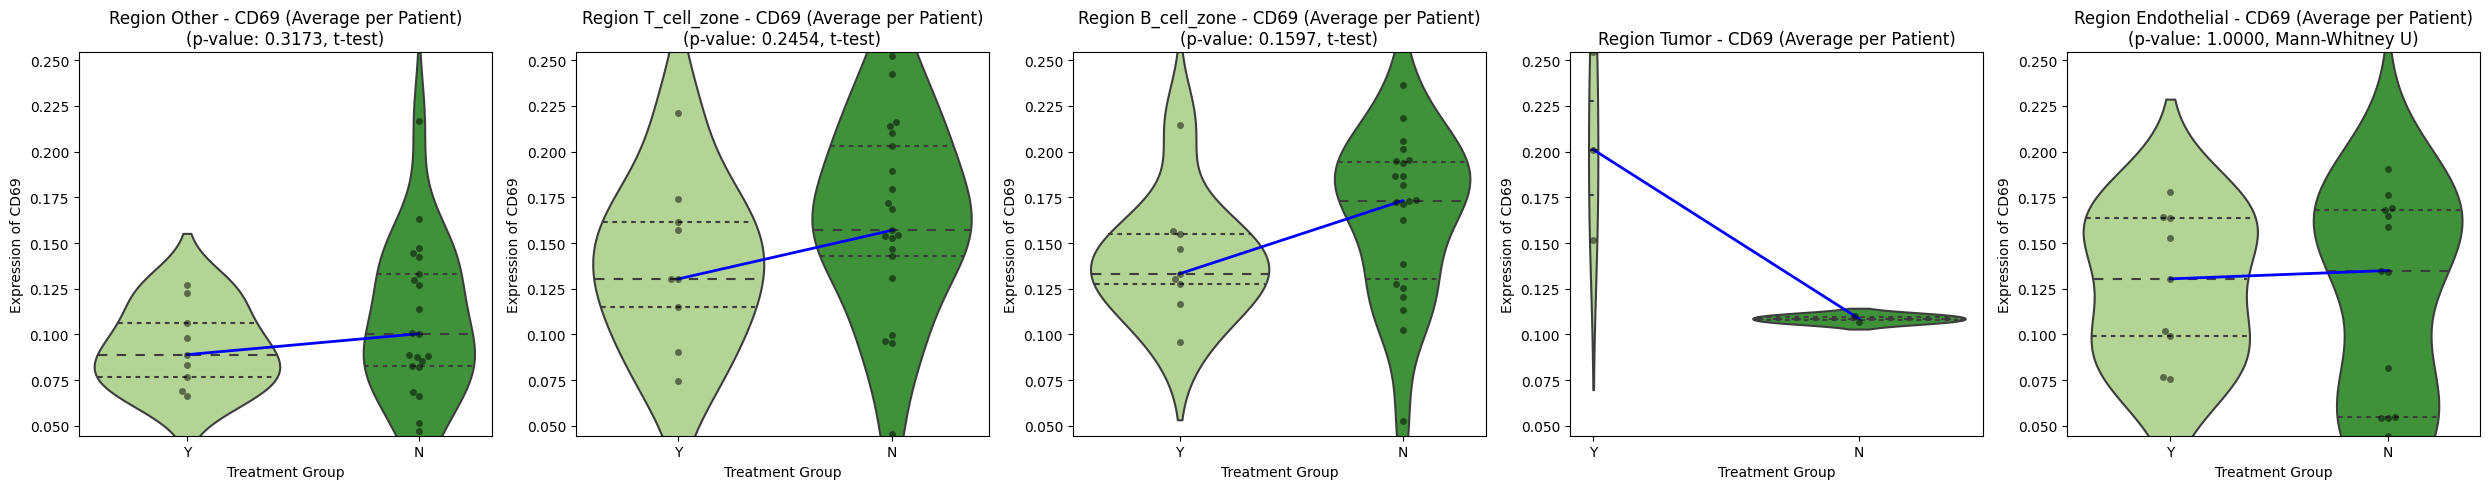

In [38]:
# Example usage
plot_marker_expression_by_region(nk_cell_data_expanded, 'CD69', palette_start=2)

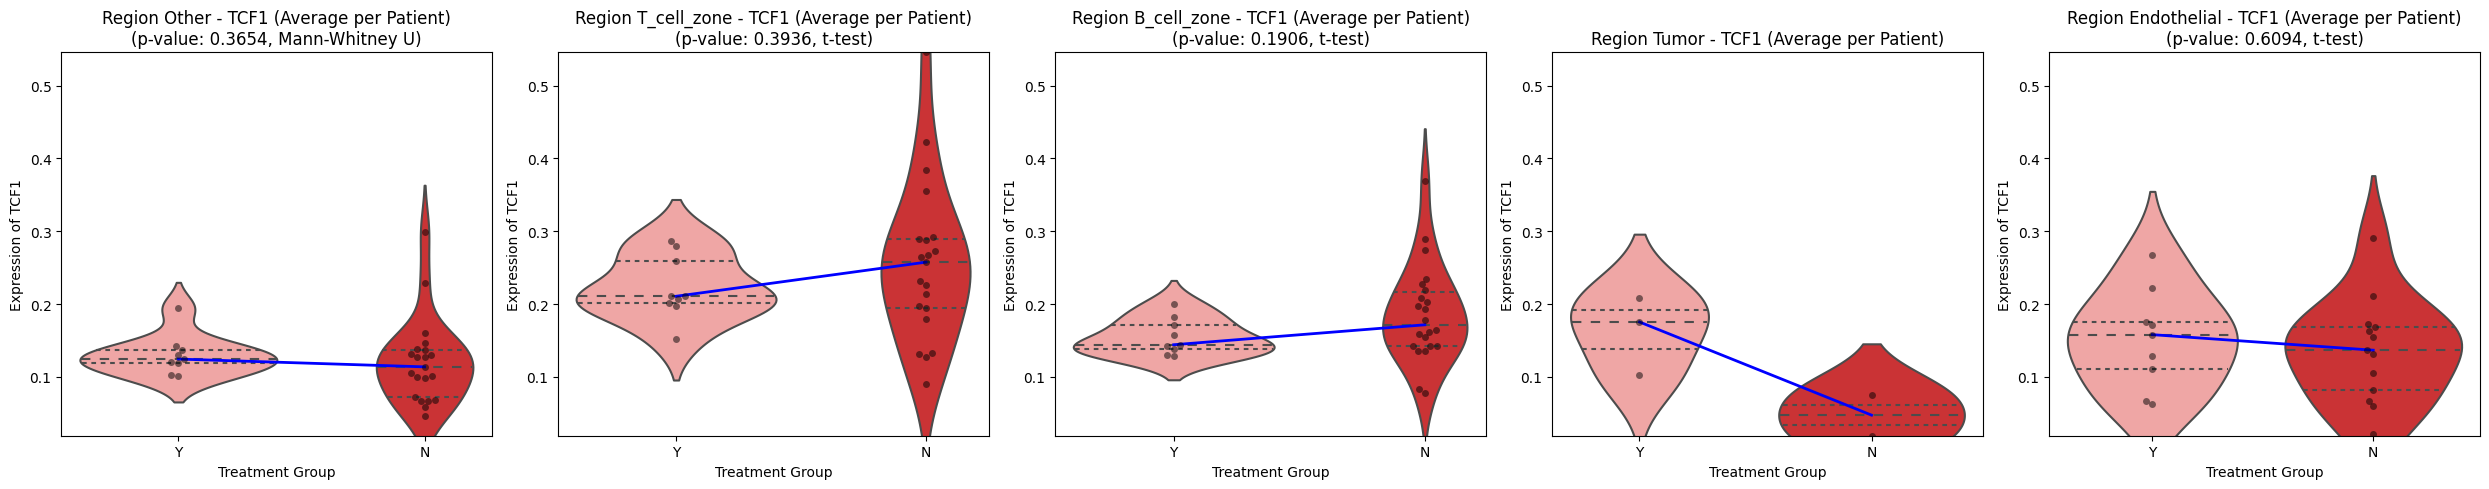

In [39]:
# Example usage
plot_marker_expression_by_region(nk_cell_data_expanded, 'TCF1', palette_start=4)

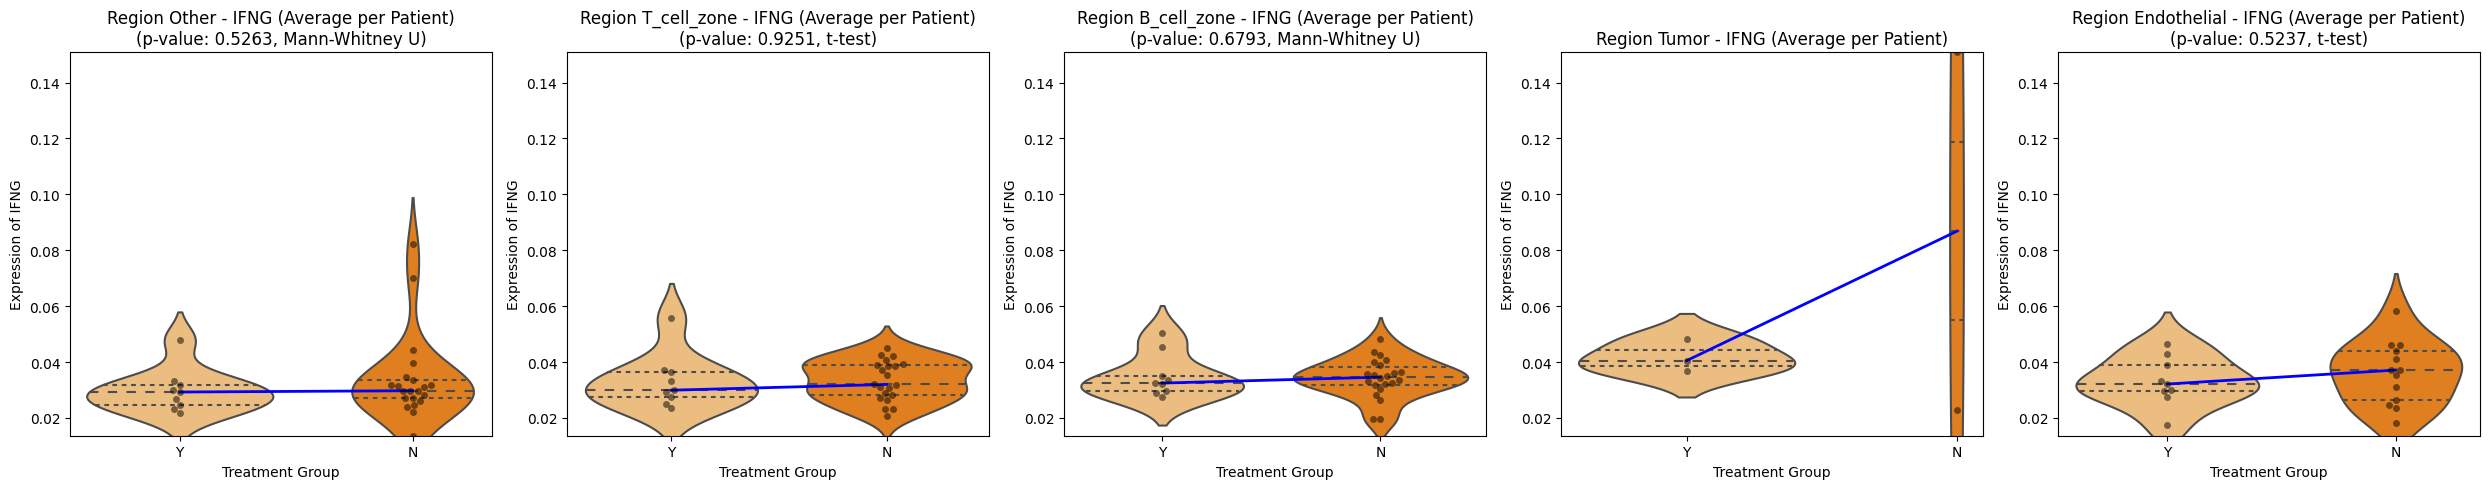

In [40]:
# Example usage
plot_marker_expression_by_region(nk_cell_data_expanded, 'IFNG', palette_start=6)

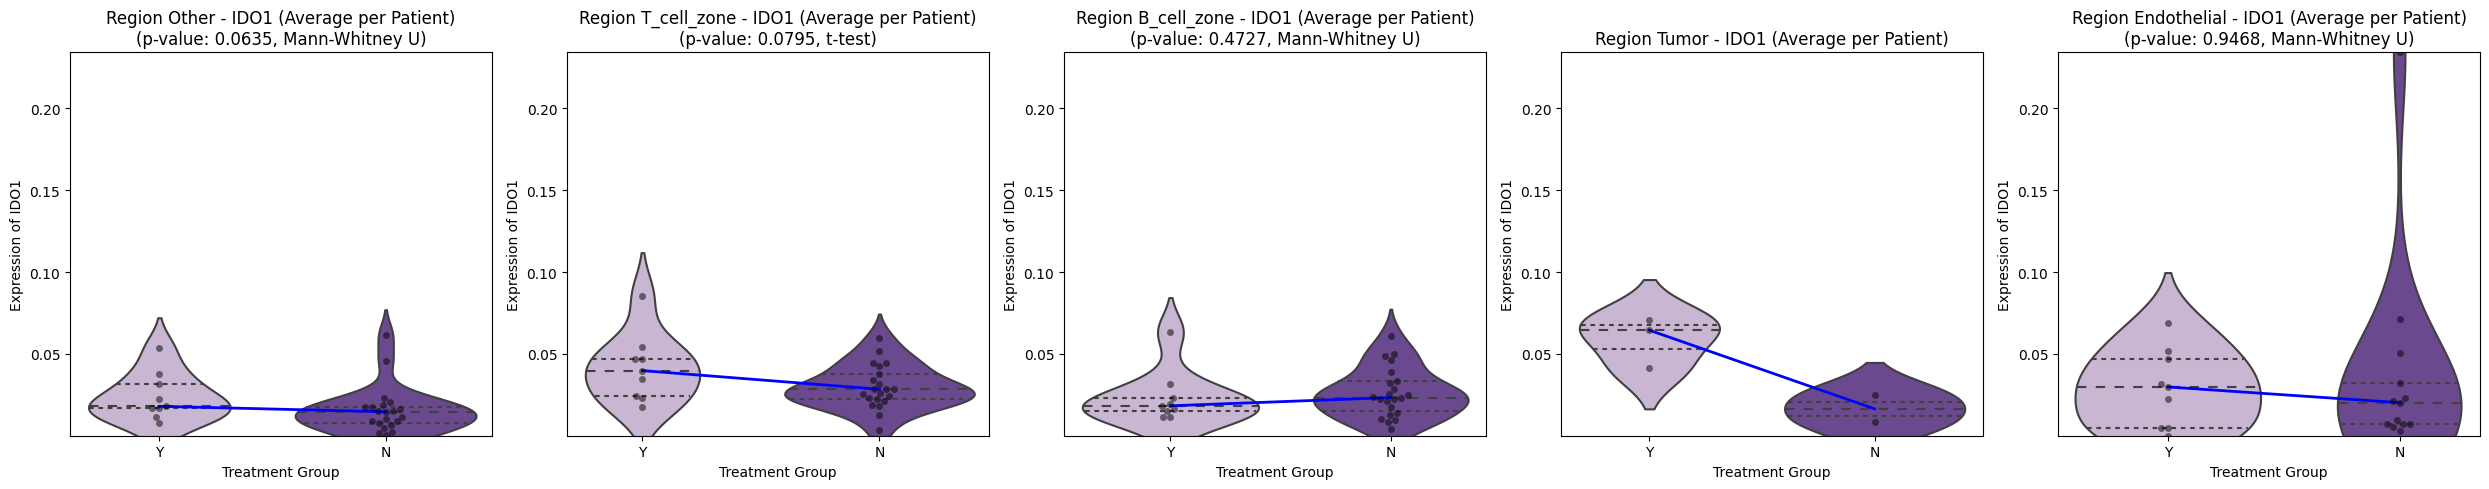

In [41]:
# Example usage
plot_marker_expression_by_region(nk_cell_data_expanded, 'IDO1', palette_start=8)

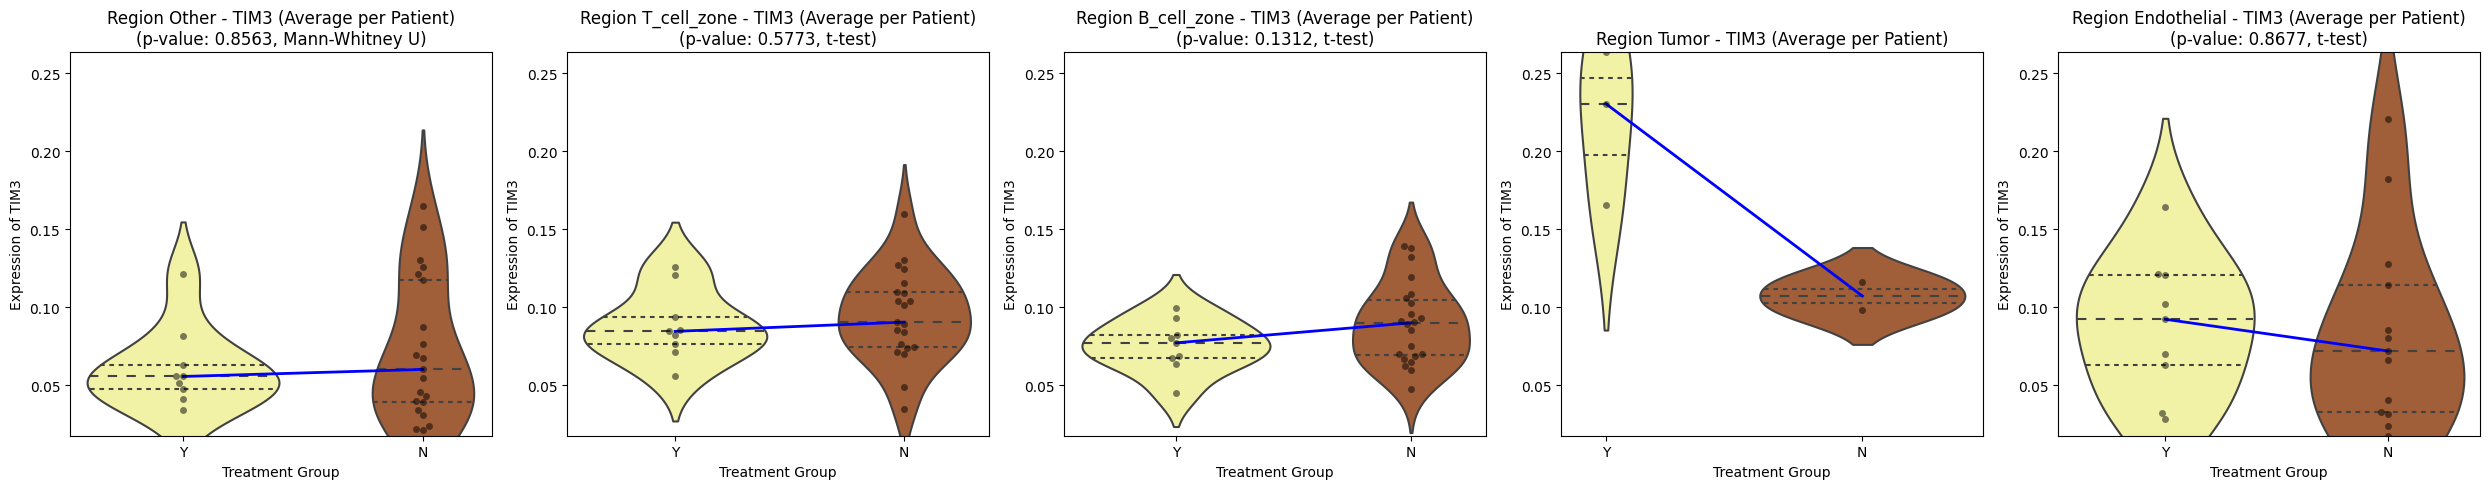

In [71]:
# Example usage
plot_marker_expression_by_region(nk_cell_data_expanded, 'TIM3', palette_start=10)

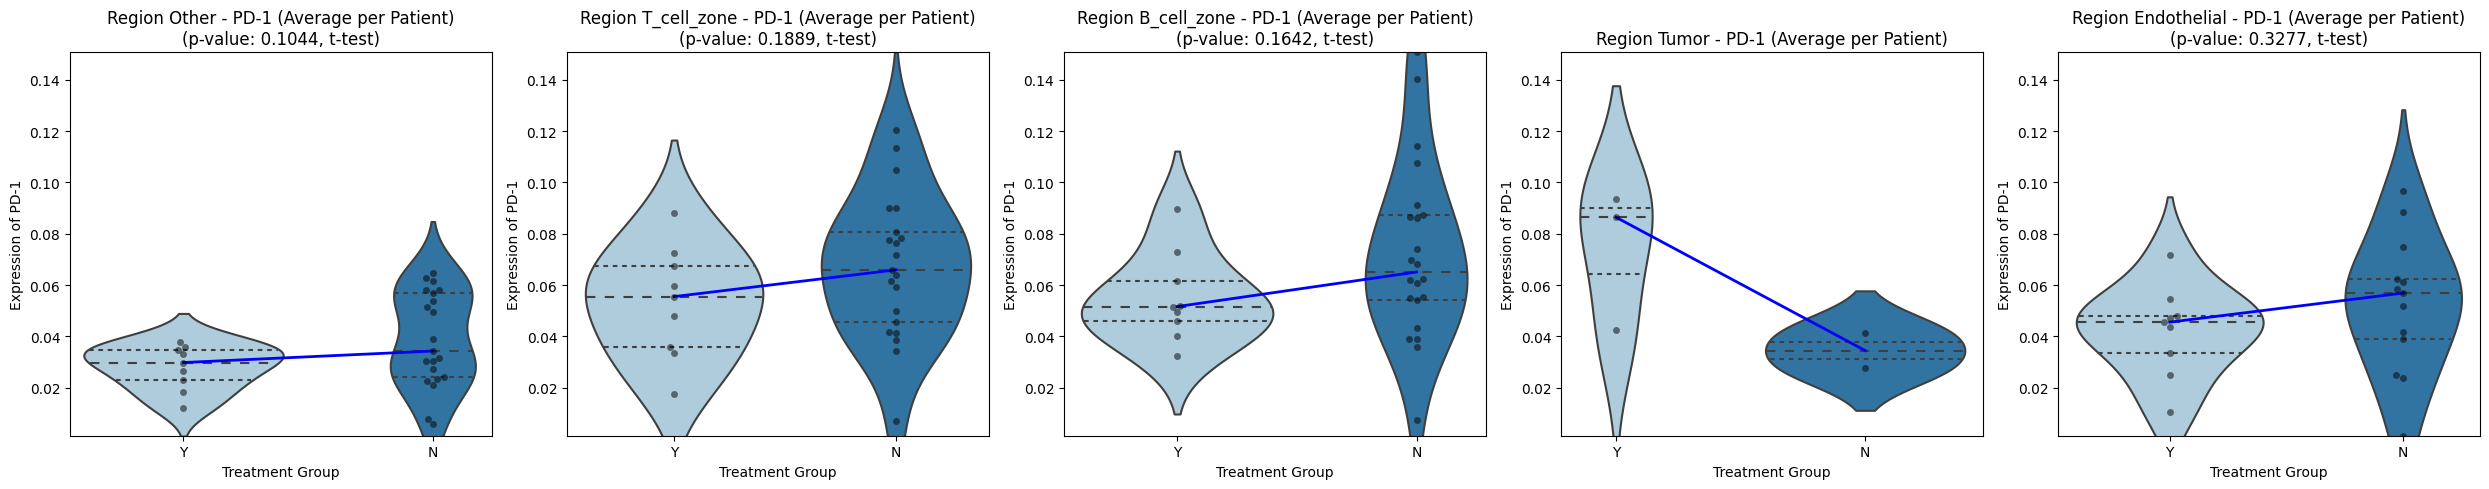

In [74]:
# Example usage
plot_marker_expression_by_region(nk_cell_data_expanded, 'PD-1', palette_start=0)

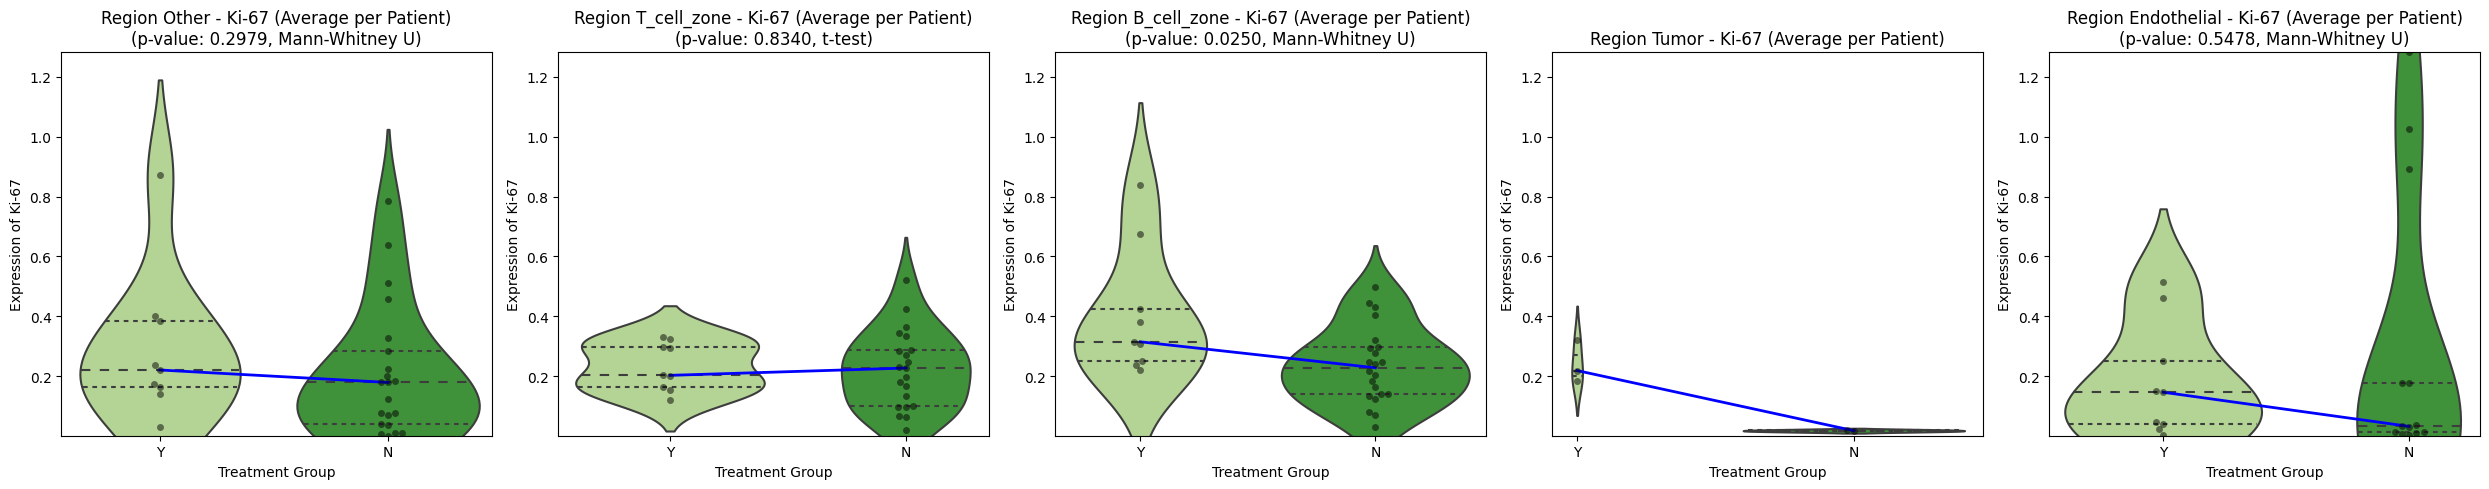

In [77]:
# Example usage
plot_marker_expression_by_region(nk_cell_data_expanded, 'Ki-67', palette_start=2)

## Now we can start to look at differences between the frequency of cells around NK cells within each region.
To start lets write a function so that we can identify a region and pull from the frequency data to find what cell types are most common around NK cells.

In [20]:
#optional read in original Maha data for some data that may have been missed per cell we want to incoroprate:
os.chdir('/krummellab/data1/DSCoLab/HNLN')
freq_data = pd.read_csv('/krummellab/data1/DSCoLab/HNLN/spatial_analysis/neighborhood_mats/neighborhood_freqs-cell_meta_cluster_radius50.csv')
os.chdir('/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_MR_NK_analysis')
os.getcwd()

'/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_MR_NK_analysis'

In [21]:
NK_cells_freq_data = freq_data[freq_data['cell_meta_cluster'] == 'NK_cell']
merge_col = ['region', 'patient_id', 'cell_meta_cluster', 'fov', 'label', 'treated']
valid_columns = [col for col in merge_col if col in cell_table.columns]
extra_data = cell_table[valid_columns]
NK_cells_freq_data_expanded = pd.merge(NK_cells_freq_data, extra_data, on=['cell_meta_cluster', 'fov', 'label'])
NK_cells_freq_data_expanded.columns

Index(['fov', 'label', 'cell_meta_cluster', 'APC_T_cell', 'BDCA3+_cell',
       'CD4+T_cell', 'Endothelial', 'B_cell', 'CD163+_Macrophage',
       'Neutrophil', 'CD8T_15', 'Treg', 'FDC_B_cell', 'Macrophage', 'Other',
       'CD8T_8', 'ECad+_Epithelial', 'CD8T_7', 'NK_cell', 'Plasma_cell',
       'CD8T_4', 'CD8T_1', 'CD8T_9', 'CD8T_5', 'CD4+CD8+T_cell',
       'CD138+ECad+_Epithelial', 'CD8T_2', 'CD8T_16', 'CD8T_18', 'CD8T_3',
       'CD8T_17', 'CD16+_Monocyte', 'CD8T_14', 'CD8T_11', 'CD8T_12', 'CD8T_10',
       'CD8T_13', 'Keratin+_Epithelial', 'CD8T_6', 'DC', 'Monocytes',
       'Reticular_cell', 'region', 'patient_id', 'treated'],
      dtype='object')

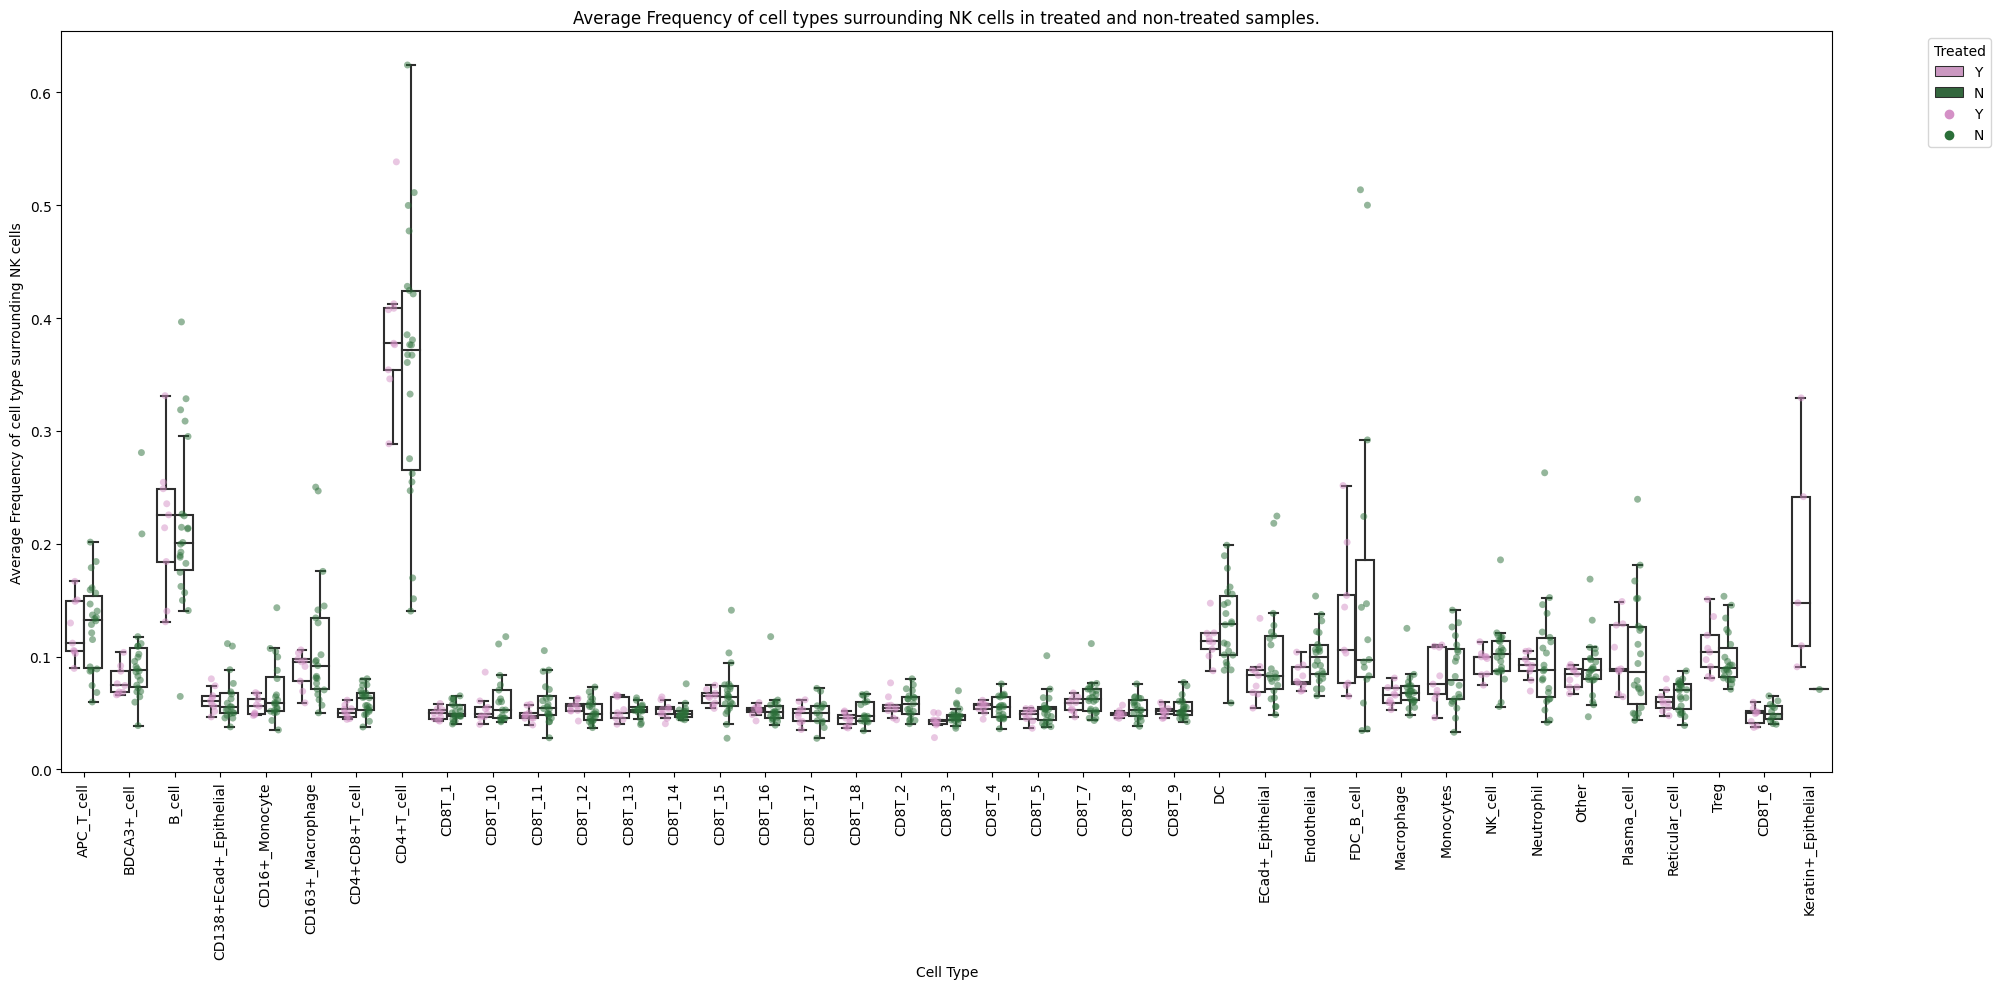

In [30]:
#create stacked bar plot for frequency of cells between treatment groups.
# List of columns to plot
columns_to_plot = ['APC_T_cell', 'BDCA3+_cell', 'CD4+T_cell', 'Endothelial', 'B_cell', 
                   'CD163+_Macrophage', 'Neutrophil', 'CD8T_15', 'Treg', 'FDC_B_cell', 
                   'Macrophage', 'Other', 'CD8T_8', 'ECad+_Epithelial', 'CD8T_7', 
                   'NK_cell', 'Plasma_cell', 'CD8T_4', 'CD8T_1', 'CD8T_9', 'CD8T_5', 
                   'CD4+CD8+T_cell', 'CD138+ECad+_Epithelial', 'CD8T_2', 'CD8T_16', 
                   'CD8T_18', 'CD8T_3', 'CD8T_17', 'CD16+_Monocyte', 'CD8T_14', 
                   'CD8T_11', 'CD8T_12', 'CD8T_10', 'CD8T_13', 'Keratin+_Epithelial', 
                   'CD8T_6', 'DC', 'Monocytes', 'Reticular_cell']

# Reshape the DataFrame
melted_data = NK_cells_freq_data_expanded.melt(id_vars=['treated', 'fov', 'patient_id', 'label'], value_vars=columns_to_plot, var_name='cell_type', value_name='value')
# Filter out zero values
melted_data_nonzero_freq_NK = melted_data[melted_data['value'] != 0]
sampled_data = melted_data_nonzero_freq_NK.sample(frac=0.1)
# Group by 'patient_id', 'treated', and 'cell_type' and calculate the mean
grouped_data = melted_data_nonzero_freq_NK.groupby(['patient_id', 'treated', 'cell_type'])['value'].mean().reset_index()
# Define a color palette
palette = sns.color_palette('cubehelix', n_colors=len(melted_data['treated'].unique()))[::-1]

# Now, you can plot this aggregated data
plt.figure(figsize=(20, 10))
sns.boxplot(data=grouped_data, x='cell_type', y='value', hue='treated', boxprops={'facecolor': 'white'}, palette=palette, showfliers=False)
sns.stripplot(data=grouped_data, x='cell_type', y='value', hue='treated', palette=palette, jitter=0.2, dodge=True, alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Average Frequency of cell type surrounding NK cells")
plt.xlabel("Cell Type")
plt.title("Average Frequency of cell types surrounding NK cells in treated and non-treated samples.")
plt.legend(title='Treated', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Looking only at the ones that have a significant difference between them. 
Average across the patients for the overall frequency of cells within 50 pixel radius of NK cells.

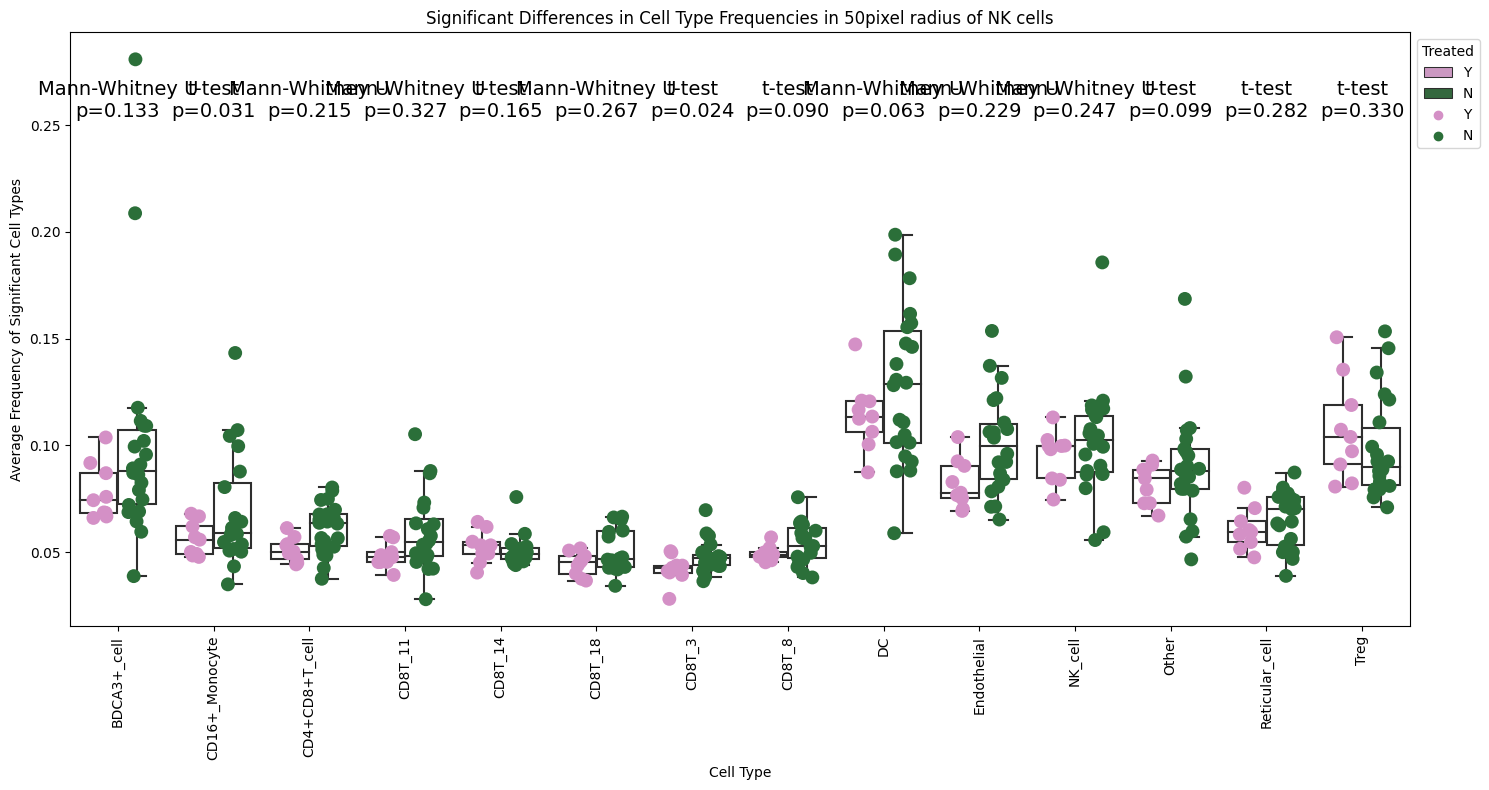

In [31]:
# Function to perform statistical tests
def perform_statistical_test(group1, group2):
    if shapiro(group1).pvalue < 0.05 or shapiro(group2).pvalue < 0.05:
        stat, p_value = mannwhitneyu(group1, group2)
        test_used = "Mann-Whitney U"
    else:
        stat, p_value = ttest_ind(group1, group2)
        test_used = "t-test"
    return p_value, test_used

# Store significant cell types and their stats
significant_cell_types = {}
for cell_type in columns_to_plot:
    treated = grouped_data[(grouped_data['cell_type'] == cell_type) & (grouped_data['treated'] == 'Y')]['value']
    untreated = grouped_data[(grouped_data['cell_type'] == cell_type) & (grouped_data['treated'] == 'N')]['value']

    if len(treated) >= 3 and len(untreated) >= 3:
        p_value, test_used = perform_statistical_test(treated, untreated)
        if p_value < 0.35:  # Adjust the p-value threshold if needed
            significant_cell_types[cell_type] = (p_value, test_used)

# Filter data to include only significant cell types
significant_data = grouped_data[grouped_data['cell_type'].isin(significant_cell_types.keys())]

# Plotting
plt.figure(figsize=(15, 8))
ax = sns.boxplot(data=significant_data, x='cell_type', y='value', hue='treated', boxprops={'facecolor': 'white'}, palette=palette, showfliers=False)
sns.stripplot(data=significant_data, x='cell_type', y='value', hue='treated', palette=palette, jitter=0.2, dodge=True, alpha=1, size=10)

# Annotate each box with the statistical test result
for i, cell_type in enumerate(significant_cell_types):
    p_value, test_used = significant_cell_types[cell_type]
    # Adjust the position of the annotation as needed
    y_position = ax.get_ylim()[1] - ((ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.15)
    ax.text(i, y_position, f'{test_used}\np={p_value:.3f}', ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
plt.ylabel("Average Frequency of Significant Cell Types")
plt.xlabel("Cell Type")
plt.title("Significant Differences in Cell Type Frequencies in 50pixel radius of NK cells")
plt.legend(title='Treated', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Ok lets look at the ditance data and see if that makes a difference in what is significant
Just going to use the same code as last time and hope to jesus that that works well.

In [3]:
#optional read in original Maha data for some data that may have been missed per cell we want to incoroprate:
os.chdir('/krummellab/data1/DSCoLab/HNLN')
dist_data = pd.read_csv('/krummellab/data1/DSCoLab/HNLN/spatial_analysis/cell_neighbor_analysis/cell_meta_cluster_avg_dists-nearest_5.csv')
os.chdir('/krummellab/data1/zachsten/personal/MIBI_data_files/HNLN_MR_NK_analysis')

NK_cells_dist_data = dist_data[dist_data['cell_meta_cluster'] == 'NK_cell']
merge_col = ['region', 'patient_id', 'cell_meta_cluster', 'fov', 'label', 'treated']
valid_columns = [col for col in merge_col if col in cell_table.columns]
extra_data = cell_table[valid_columns]
NK_cells_dist_data_expanded = pd.merge(NK_cells_dist_data, extra_data, on=['cell_meta_cluster', 'fov', 'label'])

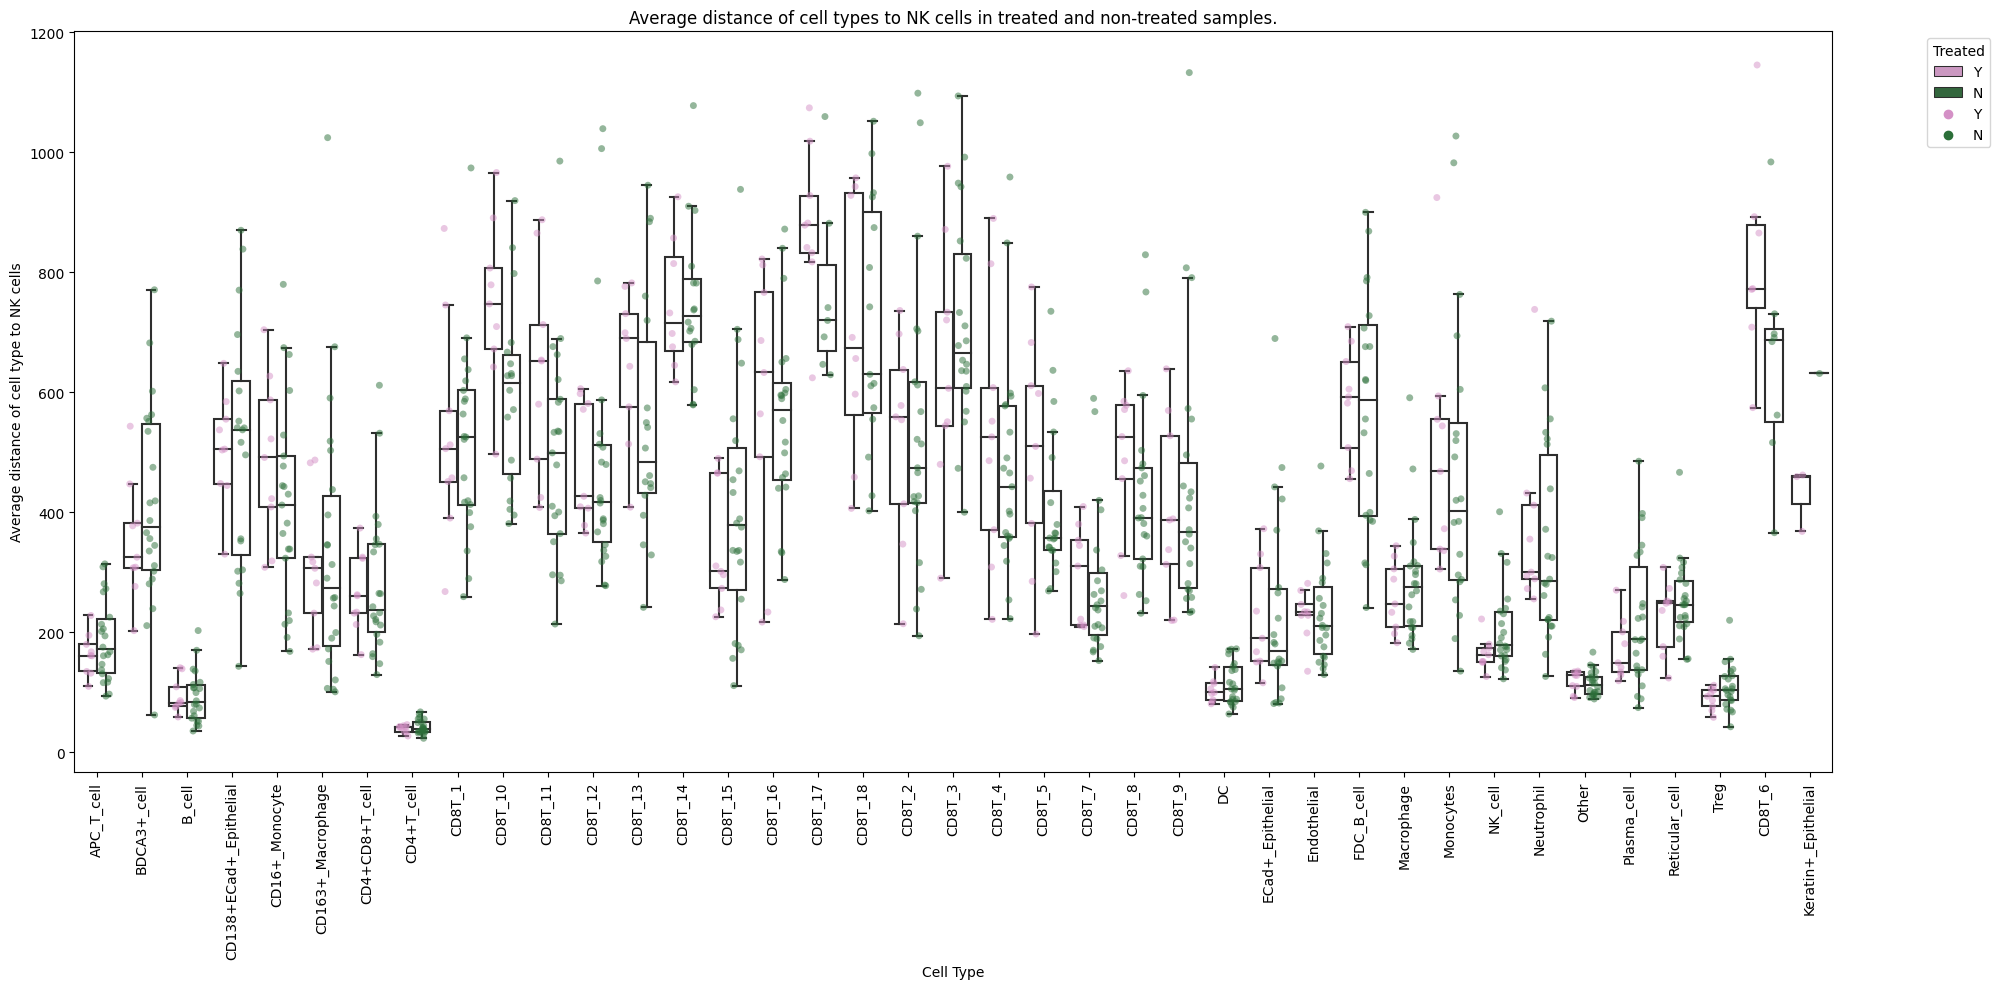

In [32]:
#create stacked bar plot for frequency of cells between treatment groups.
# List of columns to plot
columns_to_plot = ['APC_T_cell', 'BDCA3+_cell', 'CD4+T_cell', 'Endothelial', 'B_cell', 
                   'CD163+_Macrophage', 'Neutrophil', 'CD8T_15', 'Treg', 'FDC_B_cell', 
                   'Macrophage', 'Other', 'CD8T_8', 'ECad+_Epithelial', 'CD8T_7', 
                   'NK_cell', 'Plasma_cell', 'CD8T_4', 'CD8T_1', 'CD8T_9', 'CD8T_5', 
                   'CD4+CD8+T_cell', 'CD138+ECad+_Epithelial', 'CD8T_2', 'CD8T_16', 
                   'CD8T_18', 'CD8T_3', 'CD8T_17', 'CD16+_Monocyte', 'CD8T_14', 
                   'CD8T_11', 'CD8T_12', 'CD8T_10', 'CD8T_13', 'Keratin+_Epithelial', 
                   'CD8T_6', 'DC', 'Monocytes', 'Reticular_cell']

# Reshape the DataFrame
melted_data = NK_cells_dist_data_expanded.melt(id_vars=['treated', 'fov', 'patient_id', 'label'], value_vars=columns_to_plot, var_name='cell_type', value_name='value')
# Drop rows with NaN in 'value' column
melted_data = melted_data.dropna(subset=['value'])
# Filter out zero values
melted_data_nonzero_dist_NK = melted_data[melted_data['value'] != 0]
sampled_data = melted_data_nonzero_dist_NK.sample(frac=0.1)
# Group by 'patient_id', 'treated', and 'cell_type' and calculate the mean
grouped_data = melted_data_nonzero_dist_NK.groupby(['patient_id', 'treated', 'cell_type'])['value'].mean().reset_index()
# Define a color palette
palette = sns.color_palette('cubehelix', n_colors=len(melted_data['treated'].unique()))[::-1]

# Now, you can plot this aggregated data
plt.figure(figsize=(20, 10))
sns.boxplot(data=grouped_data, x='cell_type', y='value', hue='treated', boxprops={'facecolor': 'white'}, palette=palette, showfliers=False)
sns.stripplot(data=grouped_data, x='cell_type', y='value', hue='treated', palette=palette, jitter=0.2, dodge=True, alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Average distance of cell type to NK cells")
plt.xlabel("Cell Type")
plt.title("Average distance of cell types to NK cells in treated and non-treated samples.")
plt.legend(title='Treated', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

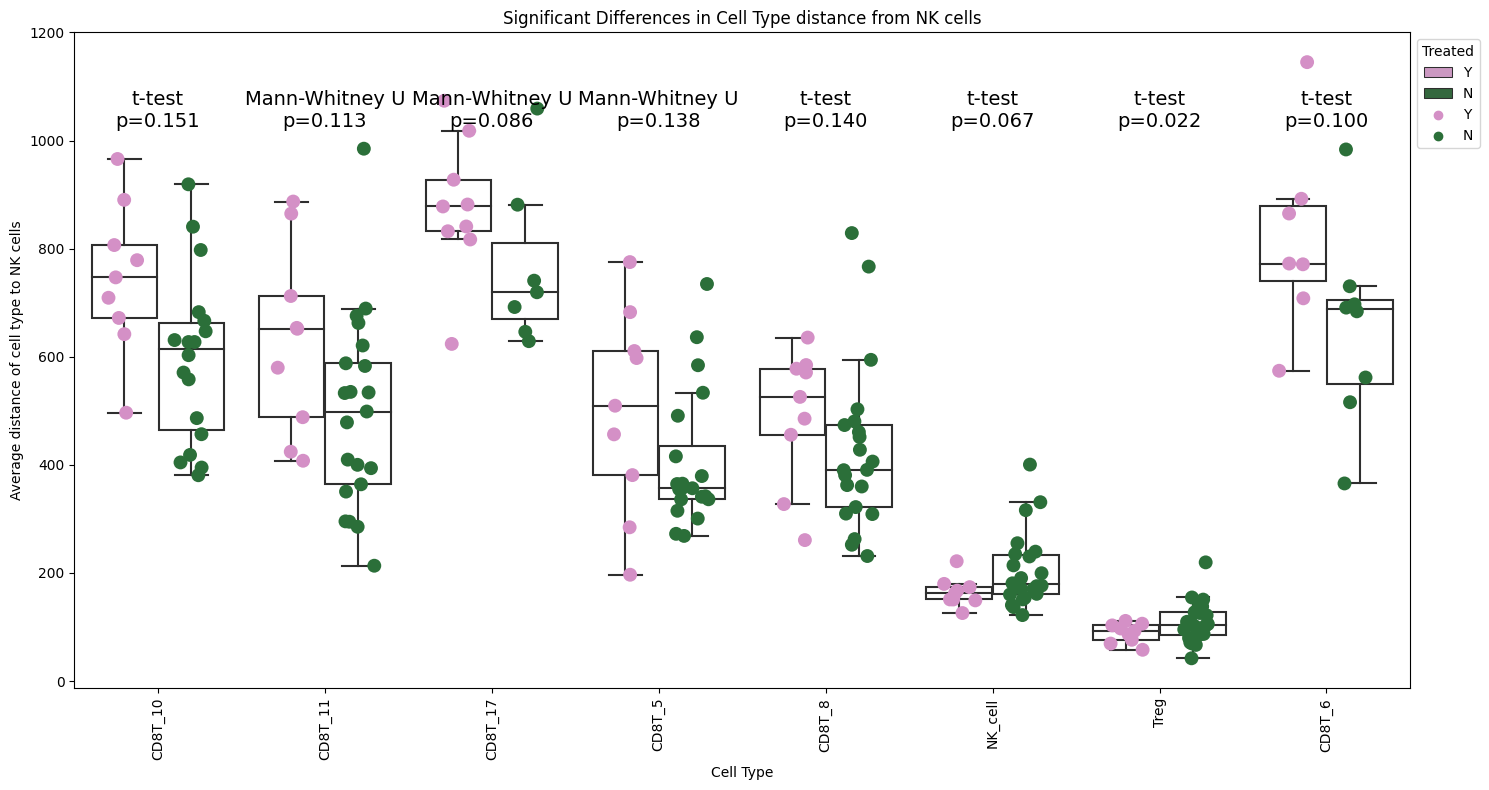

In [33]:
# Function to perform statistical tests
def perform_statistical_test(group1, group2):
    if shapiro(group1).pvalue < 0.05 or shapiro(group2).pvalue < 0.05:
        stat, p_value = mannwhitneyu(group1, group2)
        test_used = "Mann-Whitney U"
    else:
        stat, p_value = ttest_ind(group1, group2)
        test_used = "t-test"
    return p_value, test_used

# Store significant cell types and their stats
significant_cell_types = {}
for cell_type in columns_to_plot:
    treated = grouped_data[(grouped_data['cell_type'] == cell_type) & (grouped_data['treated'] == 'Y')]['value']
    untreated = grouped_data[(grouped_data['cell_type'] == cell_type) & (grouped_data['treated'] == 'N')]['value']

    if len(treated) >= 3 and len(untreated) >= 3:
        p_value, test_used = perform_statistical_test(treated, untreated)
        if p_value < 0.2:  # Adjust the p-value threshold if needed
            significant_cell_types[cell_type] = (p_value, test_used)

# Filter data to include only significant cell types
significant_data = grouped_data[grouped_data['cell_type'].isin(significant_cell_types.keys())]

# Plotting
plt.figure(figsize=(15, 8))
ax = sns.boxplot(data=significant_data, x='cell_type', y='value', hue='treated', boxprops={'facecolor': 'white'}, palette=palette, showfliers=False)
sns.stripplot(data=significant_data, x='cell_type', y='value', hue='treated', palette=palette, jitter=0.2, dodge=True, alpha=1, size=10)

# Annotate each box with the statistical test result
for i, cell_type in enumerate(significant_cell_types):
    p_value, test_used = significant_cell_types[cell_type]
    # Adjust the position of the annotation as needed
    y_position = ax.get_ylim()[1] - ((ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.15)
    ax.text(i, y_position, f'{test_used}\np={p_value:.3f}', ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
plt.ylabel("Average distance of cell type to NK cells")
plt.xlabel("Cell Type")
plt.title("Significant Differences in Cell Type distance from NK cells")
plt.legend(title='Treated', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()